In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Setup

In [5]:
symbol = 'CASH3.SA'
start_date = '2018-01-01'
end_date = '2024-07-20'

In [6]:
df = yf.download(symbol, start=start_date, end=end_date)

C:\Users\Laura\AppData\Local\Temp\ipykernel_2964\959484986.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


# Data cleaning

In [7]:
df = df[['Close']]
df.dropna(inplace=True)

In [8]:
df.head()

Price,Close
Ticker,CASH3.SA
Date,
2020-11-09,6.783152
2020-11-10,7.004730
2020-11-11,7.040468
2020-11-12,6.826038
2020-11-13,6.968992


In [9]:
df.describe()

Price,Close
Ticker,CASH3.SA
count,919.000000
mean,10.412649
std,10.252227
min,2.576009
25%,3.550709
50%,5.237885
75%,13.846049
max,52.951298


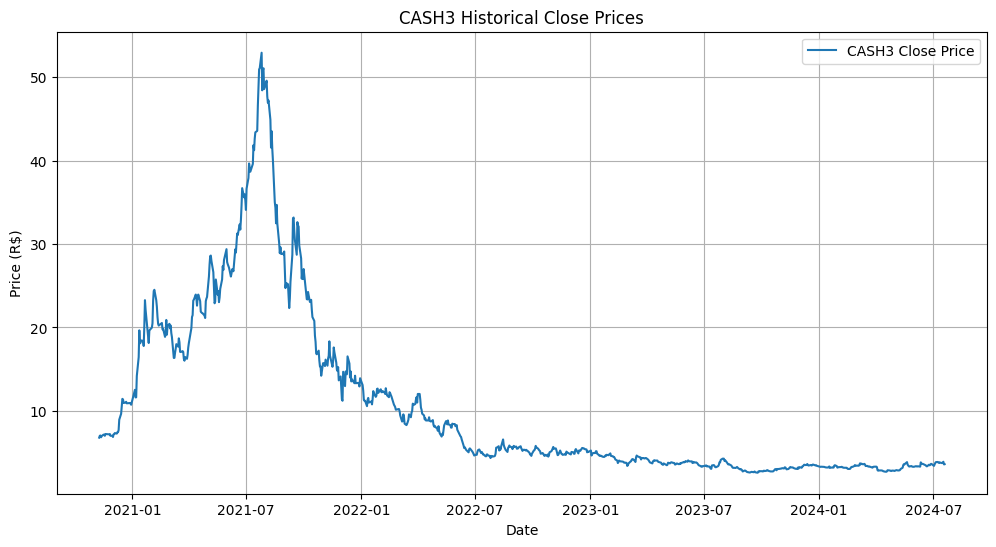

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='CASH3 Close Price')
plt.title('CASH3 Historical Close Prices')
plt.xlabel('Date')
plt.ylabel('Price (R$)')
plt.legend()
plt.grid(True)
plt.show()

# Preprocessing

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

In [12]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [13]:
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

In [14]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [15]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (687, 60, 1)
y_train shape: (687,)
X_test shape: (172, 60, 1)
y_test shape: (172,)


# Model

In [17]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)  # Output layer
])

c:\Users\Laura\OneDrive\Documentos\estudos\LLM_fiap\challenge_fase4\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0392 - val_loss: 2.3433e-04
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0046 - val_loss: 1.8032e-04
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0035 - val_loss: 3.1526e-05
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0026 - val_loss: 2.3393e-05
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0030 - val_loss: 5.5792e-05
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0022 - val_loss: 1.8722e-05
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0022 - val_loss: 2.7688e-05
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0019 - val_loss: 2.1756e-04
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0019 - val_loss: 5.0196e-05
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0022 - val_loss: 1.9122e-05
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0019 - val_loss: 3.8223e-05
Epoch 12/20
22/22 ━

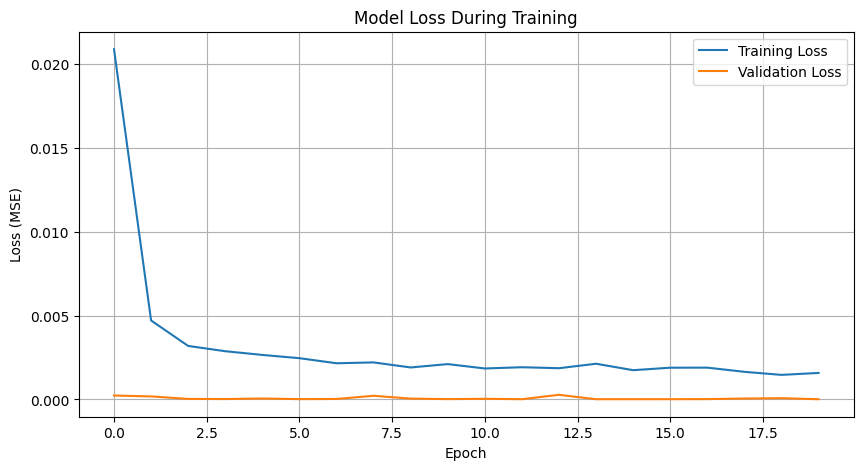

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [21]:
predictions = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [22]:
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

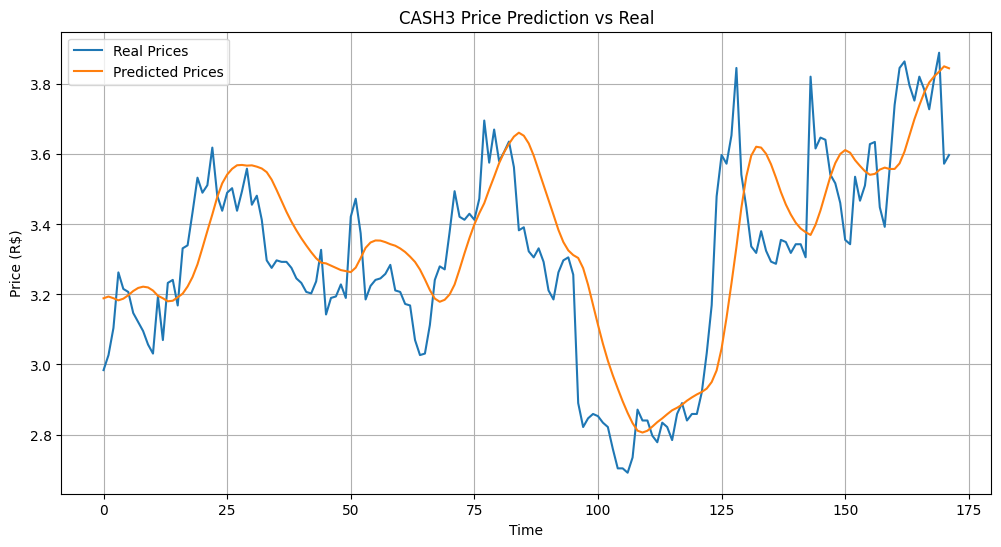

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(real_prices, label='Real Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('CASH3 Price Prediction vs Real')
plt.xlabel('Time')
plt.ylabel('Price (R$)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
mse = mean_squared_error(real_prices, predicted_prices)
print(f"MSE: {mse:.4f}")

MSE: 0.0328


In [25]:
mae = mean_absolute_error(real_prices, predicted_prices)
print(f"MAE: {mae:.4f}")

MAE: 0.1435


# Model save/load

In [26]:
import os

save_path = '../app/model/lstm_model.keras'

os.makedirs(os.path.dirname(save_path), exist_ok=True)

model.save(save_path)

In [27]:
#tf.keras.models.load_model('app/model/lstm_model.keras')

# Random prediction set generator

In [28]:
dummy = [round(10 + i * 0.1, 2) for i in range(60)]
print(dummy)

[10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9]
